In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
# Add the project root (toy-wm directory) to sys.path so we can import src as a package
# This allows relative imports within the package to work correctly
# Assumes notebook is run from the project root directory
project_root = os.getcwd()  # or use: os.path.dirname(os.path.abspath(''))
if project_root not in sys.path:
    sys.path.insert(0, project_root)




In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch as t

# Import using absolute path from src package
from src.models.dit import get_model

model = get_model(24, 24, patch_size=4, d_model=32)
model.load_state_dict(t.load('./experiments/20251102_014027/model.pt'))
model.eval()

CausalDit(
  (blocks): ModuleList(
    (0-1): 2 x CausalBlock(
      (norm1): AdaLN(
        (fc): Linear(in_features=32, out_features=64, bias=True)
      )
      (attn): Attention()
      (gate1): Gate(
        (fc_c): Linear(in_features=32, out_features=32, bias=True)
      )
      (norm2): AdaLN(
        (fc): Linear(in_features=32, out_features=64, bias=True)
      )
      (geglu): GEGLU(
        (up_proj): Linear(in_features=32, out_features=128, bias=True)
        (up_gate): Linear(in_features=32, out_features=128, bias=True)
        (down): Linear(in_features=128, out_features=32, bias=True)
        (nonlin): GELU(approximate='none')
      )
      (gate2): Gate(
        (fc_c): Linear(in_features=32, out_features=32, bias=True)
      )
    )
  )
  (patch): Patch(
    (conv): Conv2d(3, 32, kernel_size=(4, 4), stride=(4, 4))
    (flatten): Flatten(start_dim=3, end_dim=-1)
  )
  (unpatch): UnPatch(
    (unpatch): Linear(in_features=32, out_features=48, bias=True)
  )
  (action_emb

In [3]:
from src.datasets.pong1m import get_loader

loader, mean, std = get_loader(duration=1, fps=6)
frames, actions = next(iter(loader))

In [4]:
from torch.nn import functional as F
from tqdm import tqdm

@t.no_grad()
def sample(v, z, frames, actions, num_steps=10, uniform=False, device="mps"):
    if uniform: 
        ts = 1 - t.linspace(0, 1, num_steps, device=device)
    else:
        ts = 1 - F.sigmoid(t.randn(num_steps, device=device).msort())
    #print(ts)
    z_prev = z.clone()
    z_prev = z_prev.to("mps")
    for i in tqdm(range(len(ts)-1)):
        t_cond = ts[i].repeat(z_prev.shape[0], 1)
        z_prev = z_prev + (ts[i] - ts[i+1])*v(z_prev.to("mps"), frames[:, :-1].to("mps"), actions.to("mps"), t_cond.to("mps")) 
    return z_prev

In [5]:
model.to("mps")
z =sample(model, t.randn_like(frames), frames, actions)

100%|██████████| 9/9 [00:03<00:00,  2.67it/s]


In [6]:
z = z.cpu()*std + mean

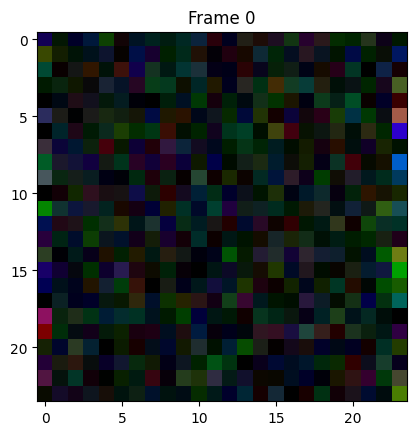

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# z[0] shape: (num_frames, height, width, 3), where num_frames = frames.shape[1]
frames_np = z[0].permute(0, 2, 3, 1).clamp(0, 1).cpu().numpy()  # shape: (num_frames, height, width, 3)

fig, ax = plt.subplots()
im = ax.imshow(frames_np[0])
ax.set_title('Frame 0')

def animate(i):
    im.set_data(frames_np[i])
    ax.set_title(f'Frame {i}')
    return [im]

ani = animation.FuncAnimation(
    fig, animate, frames=frames_np.shape[0],
    interval=200, blit=True, repeat=True
)

plt.show()

# Optional: To save the gif uncomment below (requires pillow, install with `pip install pillow`)
ani.save("sample.gif", writer="pillow")
